In [2]:
import numpy as np
from scipy import signal
from scipy import io
from scipy import fft
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In order to find signal within a sample, we 1) square the values, 2) smooth out any noise with a simple sliding window that averages all values within the window, 3) take the largest value as the signal center, and then 4) grab 1.5 seconds of audio on each side of the signal, as we know the songs of interest to all be less than 3 seconds

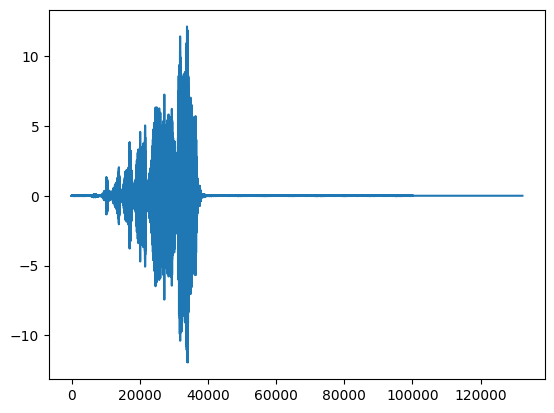

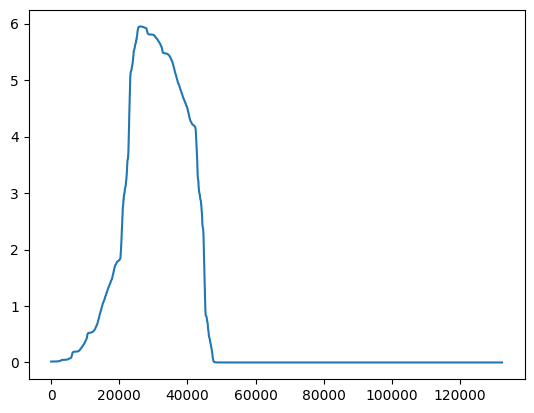

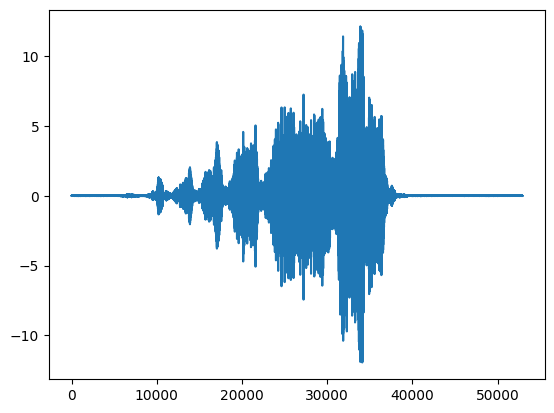

In [223]:

sr, test = io.wavfile.read("Single Birdcall Samples/iso3.wav")
m = np.mean(test)
s = np.std(test)
test2 = (test - m)/s
np.argmax(test2)

plt.plot(test2)
plt.show()

def moving_average(x, w):
    return signal.convolve(x, np.ones(w), "same") / w
    #return np.convolve(x, np.ones(w), 'valid') / w

heavily_smoothed = moving_average(test2**2, sr)

plt.plot(heavily_smoothed)
plt.show()

signal_center = np.argmax(heavily_smoothed)
half_step = int(sr*1.2)
new_start = max(0, signal_center - half_step)
cropped_test = test2[new_start:new_start + 2*half_step]
plt.plot(cropped_test)
plt.show()

In [155]:
from IPython.display import Audio
Audio(data=cropped_test, rate=sr)

This will be a tricky one to analyze as the majority of the signal, aside from the closing hook, is extremely faint.

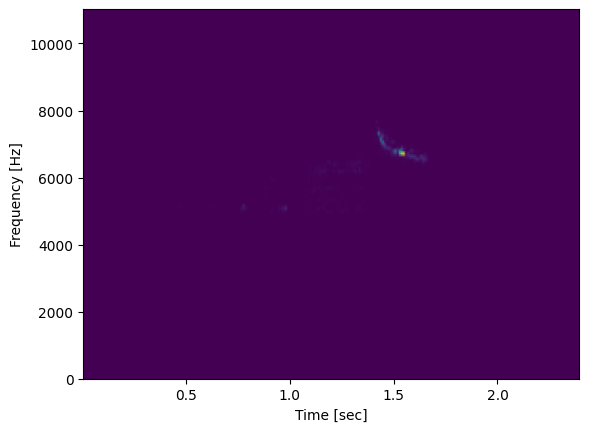

In [235]:
plt.set_cmap('viridis')
f_spec, t_spec, Sxx = signal.spectrogram(cropped_test, sr)
plt.pcolormesh(t_spec, f_spec, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

At heart, finding the minimum and maximum frequency is about thresholding a somewhat arbitrary boundary. This suggests that we might leverage edge detection algorithms to identify those boundaries, where picking the highest and lowest detected edges in the isolated audio file should correspond to the maximum and minimum frequency. We'll first visualize a simple sobel filter, then employ a more sophisticated Canny filter for edge detection.

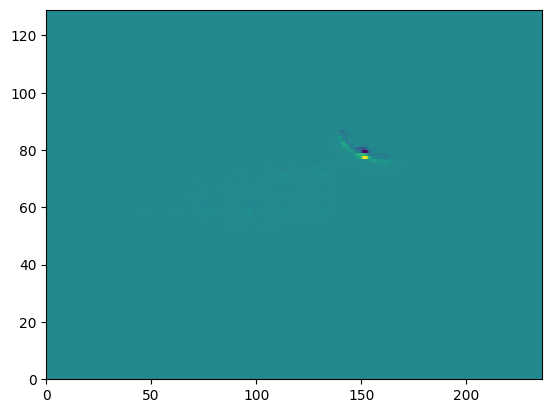

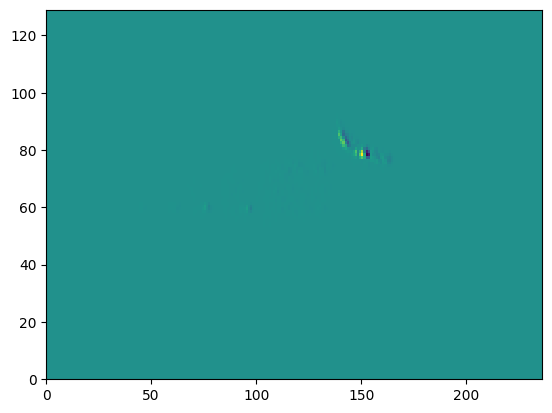

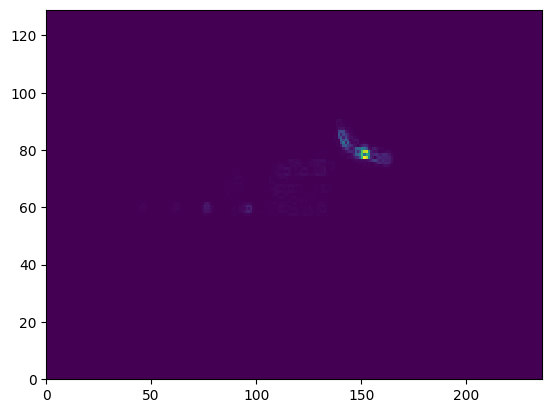

In [236]:
from scipy import ndimage

sobel_h = ndimage.sobel(Sxx, 0)  # horizontal gradient
sobel_v = ndimage.sobel(Sxx, 1)  # vertical gradient
magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
plt.pcolormesh(sobel_h)
plt.show()
plt.pcolormesh(sobel_v)
plt.show()
plt.pcolormesh(magnitude)
plt.show()


Despite the challenge of this signal, Canny picks up the major areas of signal, even the very faint ones.

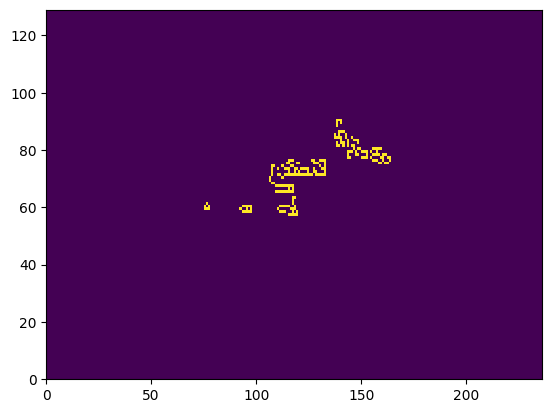

In [246]:
import cv2

Sxx_int = (Sxx*255).astype(np.uint8)
# Apply Canny
edges = cv2.Canny(Sxx_int, 1, 5, 1, L2gradient=True)

plt.pcolormesh(edges)
#plt.pcolormesh(Sxx_int)

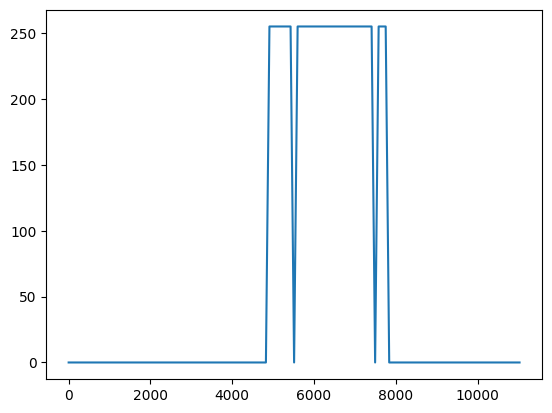

In [240]:
edge_presence_by_frequency_bin = np.max(edges, axis=1)
plt.plot(f_spec, edge_presence_by_frequency_bin)


In [242]:
#f_spec[edge_presence_by_frequency_bin == 255]
detections = f_spec[edge_presence_by_frequency_bin == 255]
print("Max frequency: ", str(detections[-1]))
print("Min frequency: ", str(detections[0]))

Max frequency:  7751.953125
Min frequency:  4909.5703125


Wrap up everything we've done so far into a function. The only real change is to use a high nfft value during spectrogram generation, prioritizing frequency over time in the FFT's time-frequency tradeoff.

In [244]:
def get_edges(filename):
    # Load and normalize
    sr, test = io.wavfile.read(filename)
    m = np.mean(test)
    s = np.std(test)
    test2 = (test - m)/s

    # Smooth data and crop to signal
    def moving_average(x, w):
        return signal.convolve(x, np.ones(w), "same") / w
    heavily_smoothed = moving_average(test2**2, sr)
    signal_center = np.argmax(heavily_smoothed)
    
    half_step = int(sr*1.5)
    new_start = max(0, signal_center - half_step)
    cropped_test = test2[new_start:new_start + 2*half_step]

    # Calculate spectrogram and apply edge detection
    f_spec, t_spec, Sxx = signal.spectrogram(cropped_test, sr, nfft=10000)
    Sxx_int = (Sxx*255).astype(np.uint8)
    edges = cv2.Canny(Sxx_int, 1, 5, 1, L2gradient=True)
    edge_presence_by_frequency_bin = np.max(edges, axis=1)
    detections = f_spec[edge_presence_by_frequency_bin == 255]
    return detections

We will test the consistency of source separation by applying the same preprocessing and Canny edge detection steps to 1) a clean input signal and 2) the clean signal mixed with noise then run through source separation, producing a neural-network-estimated clean signal. This is a relative rather than absolute metric. The premise is that, whatever our method of estimating minimum and maximum frequencies, we should get the same estimates from the true signal as we get from the estimator of the true signal. This doesn't say that the values themselves are the same as an expert would find, but that source separation is sufficiently robust for it not to shift the values returned by an arbitrary objective metric.

For the majority of samples, Canny works incredibly well. In many cases we achieve perfect reproduction (eg 4312.9800000000005 minimum frequency in the original signal, 4312.9800000000005 in the isolated signal). For a handful of samples, it is significantly wrong (2718 vs 3647), suggesting that more fine-tuning would help in bringing these methods into production. Because the good samples outnumber the outliers, the mean absolute percentage error is in the single digits.

In [247]:
# files = [
#     "Single Birdcall Samples/iso1.wav",
#     "Single Birdcall Samples/iso3.wav",
#     "Single Birdcall Samples/iso5.wav",
#     "Single Birdcall Samples/iso7.wav",
#     "Single Birdcall Samples/iso9.wav",
#     "Single Birdcall Samples/iso11.wav",
#     "Single Birdcall Samples/iso13.wav",
#     "Single Birdcall Samples/iso15.wav",
#     "Single Birdcall Samples/iso17.wav",
#     "Single Birdcall Samples/iso19.wav"
#     ]


# get_max(files[1])

pure_source_max=[]
pure_source_min=[]
isolated_source_max=[]
isolated_source_min=[]
mape_min = 0
mape_max = 0
for i in range(10):
    fn1 = "Single Birdcall Samples/iso" + str(2*i+1) + ".wav"
    fn2 = "Single Birdcall Samples/estiso" + str(2*i+1) + ".wav"
    detections1 = get_edges(fn1)
    detections2 = get_edges(fn2)
    pure_source_max.append(detections1[-1])
    isolated_source_max.append(detections2[-1])
    pure_source_min.append(detections1[0])
    isolated_source_min.append(detections2[0])    
    mape_min = mape_min + np.abs((detections1[-1]-detections2[-1])/detections1[-1])
    mape_max = mape_max + np.abs((detections1[0]-detections2[0])/detections1[0])
mape_min = 100*mape_min/len(pure_source_min)
mape_max = 100*mape_max/len(pure_source_max)

print("Maximums:")
print(pure_source_max)
print(isolated_source_max)
print(mape_max)
print("Minimums:")
print(pure_source_min)
print(isolated_source_min)
print(mape_min)




Maximums:
[7025.13, 7741.755, 6162.975, 7111.125, 6892.83, 7598.43, 7706.475, 7466.13, 7446.285, 6350.400000000001]
[7009.695000000001, 7391.16, 6162.975, 7117.74, 7325.01, 7580.79, 7702.0650000000005, 7463.925, 7446.285, 6350.400000000001]
5.925835809153395
Minimums:
[2718.765, 4928.175, 4495.995, 3625.02, 3578.715, 5036.22, 4312.9800000000005, 4619.475, 4784.85, 3442.005]
[3647.07, 4279.905, 4498.2, 3644.8650000000002, 3922.695, 5124.42, 4312.9800000000005, 4619.475, 4784.85, 3442.005]
1.1430263618494165
